# 2. Решение задачи средствами классического ML

На этом этапе необходимо выполнить следующие задачи:

- Провести векторизацию текстовых документов с помощью `TF-IDF`.
- Выбор метрик для оценки моделей
- Решить поставленную задачу проектами такими алгоритмами как `LogisticRegression`, `Naive Bayes`, `CatBoost`.
- Провести MLflow эксперименты.

In [2]:
import pandas as pd
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
import mlflow
import seaborn as sb
import matplotlib.pyplot as plt

PROJECT_ROOT = Path().resolve().parents[0]
print(PROJECT_ROOT)
DATA_DIR_PATH = Path(PROJECT_ROOT / 'data/processed')
print(DATA_DIR_PATH)

C:\Users\kiril\OneDrive\Рабочий стол\Учёба\ML проекты\Classification-of-customer-requests-in-the-banking-sector
C:\Users\kiril\OneDrive\Рабочий стол\Учёба\ML проекты\Classification-of-customer-requests-in-the-banking-sector\data\processed


## 2.1 Векторизация текстовых докуметов

Поскольку модели машинного обучения не умеют работать с чистым текстом, его нужно как-то представить в виде чисел. `TF-IDF` - статистическая модель, с помощью которой мы будем строить вектора для наших текстовых документов. Идея метода заключается в том, что вес слова в документе должен быть пропорционален его частоте в этом документе (локальный компонент) и обратно пропорционален его частоте во всем корпусе документов (глобальный компонент). Слова, которые часто встречаются в конкретном документе, но редко в остальных, получают наибольший вес.

**TF (Term Frequency):**  

$$TF(t, d) = \frac{Количество\space вхождений\space слова\space t\space в\space документ\space d}{Общее\space число\space слов\space в\space документе\space d}$$

**IDF (Inverse Document Frequency):**

$$IDF(t) = \log\left(\frac{N}{df(t) + 1}\right)$$

где `N` - число слов в документе; `df(t)` - число документов, содержащих слово `t`.

**TF-IDF:**

$$TF\text{-}IDF(t, d) = TF(t, d) \cdot IDF(t)$$

Загрузим наши выборки.

In [3]:
train_df = pd.read_csv(DATA_DIR_PATH / 'train_df.csv')
val_df = pd.read_csv(DATA_DIR_PATH / 'val_df.csv')
test_df = pd.read_csv(DATA_DIR_PATH / 'test_df.csv')

X_train, y_train = train_df['text'], train_df['label']
X_val, y_val = val_df['text'], val_df['label']
X_test, y_test = test_df['text'], test_df['label']

Инициализируем `TF-IDF` векторизатор.

In [4]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    max_features=50000,
    sublinear_tf=True
)

- Параметр `ngram_range` определяет диапазон n-грамм, которые будут использоваться при построении векторного представления текста.
- Параметр `min_df` опреляет минимальное количество вхождений термы в документ. Если меньше, то слово отбрасывается.
- Параметр `max_df` определяет долю максимального количества вхохдений термы в документ. Отбрасывает стоп-слова.
- Параметр `max_features` определяет размерность словаря терм, где ключ - терма, значение - вес термы.
- Параметр `sublinear_tf` отпределяет сглаживание влияния частых термов.

## 2.2 Выбор метрик оценивания

В качестве метрик, по которым мы будем оценивать модели, были выбраны:

- `Accuracy` - простая в понимании базовая метрика, которая показывает количество правильных предсказаний среди общего числа предсказаний

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} = \frac{\text{количество правильных предсказаний}}{\text{общее количество объектов}}
$$

- `Precision` - измеряет долю правильно положительных предсказаний среди всех предсказанных как положительные.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

- `Recall` - измеряет долю найденных положительных объектов среди всех истинно положительных.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

- `F1-Score` - гармоническое среднее `precision` и `recall`, обеспечивающее баланс между ними:

$$
F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Поскольку у нас мультиклассовая классификация, то будем использовать метрику F1-macro (Среднее f1 по всем классам):

$$
F_1^{\text{macro}} = \frac{1}{K} \sum_{c=1}^{K} F_{1,c}
$$

- Также важно дополнительно смотреть на матрицу ошибок (`confusion matrix`), которая показывает ошибки моделей в предсказании класса объекта.

**ВЫВОД:** Целевая метрика - `F1-macro`.

Создадим функцию, с помощью которой будем оценивать наши алгоритмы

In [5]:
def evaluate(model,X, y_true):
    y_pred = model.predict(X)
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'f1_score': f1_score(y_true, y_pred, average='macro')
    }

## 2.3 Применение алгоритмов классического ML

### Logistic Regression

Логистическая регрессия - базовый линейный алгоритм, который позволяет посчитать вероятность принадлежности объекта к одному из классов.

**Суть**: Пусть $x \in \mathbb{R}^d$ - вектор признаков объекта (TF-IDF вектор текста), $w \in \mathbb{R}^d$ - вектор весов модели, $b \in \mathbb{R}$ - свободный член (смещение). Тогда линейная комбинация признаков вычисляется как:

$$
z = w^T x + b = \sum_{j=1}^{d} w_j x_j + b
$$

Для многоклассовой классификации, в нашем случае, используется функция - **softmax функция**, которая преобразует линейную комбинацию модели в вероятность:

$$
\text{Softmax}(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$

Построим pipeline для LogisticRegression модели

In [6]:
logistic_regression_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('classification', LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    ))
])

### Naive Bayes

Наивный байесовский классификатор - основан на теореме Байеса. Алгоритм называется «наивным» из-за сильного допущения о независимости признаков. В нашем случае наличие или отсутствие каждого слова в тексте не зависит от наличия или отсутствия других слов.

Теорема Байеса для классификации формулируется следующим образом. Для объекта $x$ и класса $c$:

$$
P(c | x) = \frac{P(x | c) P(c)}{P(x)}
$$

где $P(c | x)$ - апостериорная вероятность класса $c$ при наблюдении объекта $x$ (то, что мы хотим предсказать), $P(x | c)$ - вероятность наблюдать объект $x$ при условии класса $c$, $P(c)$ - априорная вероятность класса, $P(x)$ — маргинальная вероятность объекта.

Для многоклассовой классификации мы выбираем класс с максимальной апостериорной вероятностью:

$$
\hat{c} = \arg\max_{c \in C} P(c | x) = \arg\max_{c \in C} \frac{P(x | c) P(c)}{P(x)}
$$

Поскольку $P(x)$ одинакова для всех классов, задача сводится к максимизации $P(x | c) P(c)$.

Построим пайплайн для наивного байеса

In [6]:
naiveBayes_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('classification', MultinomialNB())
])

### CatBoost

Является улучшенной реализацией градиентного бустинга и возможностью обработки категориальных признаков (отсюда и название).

Как работает:
1. Последовательно строятся деревья, каждое из которых исправляет ошибки предыдущих:
   $$
   F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)
   $$
   где $h_m$ — новое дерево, $\nu$ — learning rate.
2. Автоматически преобразует категории в числовые признаки через статистики (частоту, среднее целевой переменной).
3. Симметричные деревья ускоряют обучение и повышает качество.

Инициализируем модель **CatBoostClassifier**

In [7]:
catboost_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=8,
    loss_function='MultiClass',
    verbose=False
)

### Настройка mlflow

In [ ]:
mlflow.set_tracking_uri(f"sqlite:///{(PROJECT_ROOT / 'mlflow_config' / 'mlflow.db').as_posix()}")
mlflow.set_experiment("Banking77_Classical")

2026/01/12 12:00:05 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/12 12:00:05 INFO mlflow.store.db.utils: Updating database tables
2026/01/12 12:00:05 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/12 12:00:05 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/12 12:00:05 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/12 12:00:05 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/12 12:00:05 INFO mlflow.tracking.fluent: Experiment with name 'classification_classicML_banking77' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///c:/Users/kiril/OneDrive/Рабочий стол/Учёба/ML '
 'проекты/Classification-of-customer-requests-in-the-banking-sector/notebooks/mlruns/3'), creation_time=1768197605547, experiment_id='3', last_update_time=1768197605547, lifecycle_stage='active', name='classification_classicML_banking77', tags={}>

### Прогон моделей

#### LogisticRegression

In [8]:
with mlflow.start_run(run_name='logistic_regression_tfidf'):
    logistic_regression_pipeline.fit(X_train, y_train)
    metrics = evaluate(logistic_regression_pipeline, X_val, y_val)

    mlflow.log_params({
        "model": "LogisticRegression",
        "ngram_range": "1-2",
        "max_feature": 50000,
        "class_weighted": 'balanced'
    })

    mlflow.log_metrics(metrics)

#### NaiveBayes

In [ ]:
with mlflow.start_run(run_name="naive_bayes_tfidf"):
    naiveBayes_pipeline.fit(X_train, y_train)
    metrics = evaluate(naiveBayes_pipeline, X_val, y_val)

    mlflow.log_params({
        "model": "MultinomialNB",
        "ngram_range": "1-2",
        "max_features": 50000,
        "verbose": False
    })

    mlflow.log_metrics(metrics)

#### CatBoostClassifier

In [ ]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

with mlflow.start_run(run_name="catboost_tfidf"):
    catboost_model.fit(X_train_tfidf, y_train)
    
    y_pred = catboost_model.predict(X_val_tfidf)
    
    metrics = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, average='macro'),
        'recall': recall_score(y_val, y_pred, average='macro'),
        'f1_score': f1_score(y_val, y_pred, average='macro')
    }

    mlflow.log_params({
        "model": "CatBoost",
        "iterations": 300,
        "depth": 8,
        "learning_rate": 0.1
    })

    mlflow.log_metrics(metrics)


Сделаем вывод результатов в форме **DataFrame**

In [30]:
def fit_predict_models(models, X_train, y_train, X_val, y_val):
    results = {}
    for model in models:
        model_name = str(model.get_params()['steps'][1][1]).split('(')[0]
        model.fit(X_train, y_train)
        metrics = evaluate(model, X_val, y_val)  
        results[f'{model_name}'] = metrics

    return results

classic_models = [logistic_regression_pipeline, naiveBayes_pipeline]
results = fit_predict_models(classic_models, X_train, y_train, X_val, y_val)

catboost_model.fit(X_train_tfidf, y_train)
catboost_metrcis = evaluate(catboost_model, X_val_tfidf, y_val)

results['CatBoostClassifier'] = catboost_metrcis

results_df = pd.DataFrame(results).T
results_df.sort_values('f1_score', ascending=False)

,accuracy,precision,recall,f1_score
LogisticRegression,0.847576,0.853882,0.843820,0.844536
CatBoostClassifier,0.785607,0.803400,0.769113,0.775000
MultinomialNB,0.797601,0.802574,0.760550,0.764044


## 2.5 Оценки на **test**-выборке лучше модели

Оценим нашу лучшую модель по метрике `F1_score` на тестовом датасете

In [9]:
logistic_regression_pipeline.fit(X_train, y_train)
best_metrics = evaluate(logistic_regression_pipeline, X_test, y_test)
print(best_metrics)

{'accuracy': 0.8655844155844156, 'precision': 0.8719867276707242, 'recall': 0.8655844155844157, 'f1_score': 0.8655207602974144}


Построим отчет о классификации, а также построим матрицу ошибок

In [10]:
y_pred = logistic_regression_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        40
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40
           3       0.92      0.82      0.87        40
           4       1.00      0.90      0.95        40
           5       0.76      0.70      0.73        40
           6       0.80      0.88      0.83        40
           7       0.89      0.78      0.83        40
           8       0.90      0.93      0.91        40
           9       0.91      1.00      0.95        40
          10       0.81      0.85      0.83        40
          11       0.80      0.82      0.81        40
          12       0.83      0.88      0.85        40
          13       0.95      0.97      0.96        40
          14       0.69      0.88      0.77        40
          15       0.91      0.78      0.84        40
          16       0.78      0.72      0.75        40
          17       0.88    

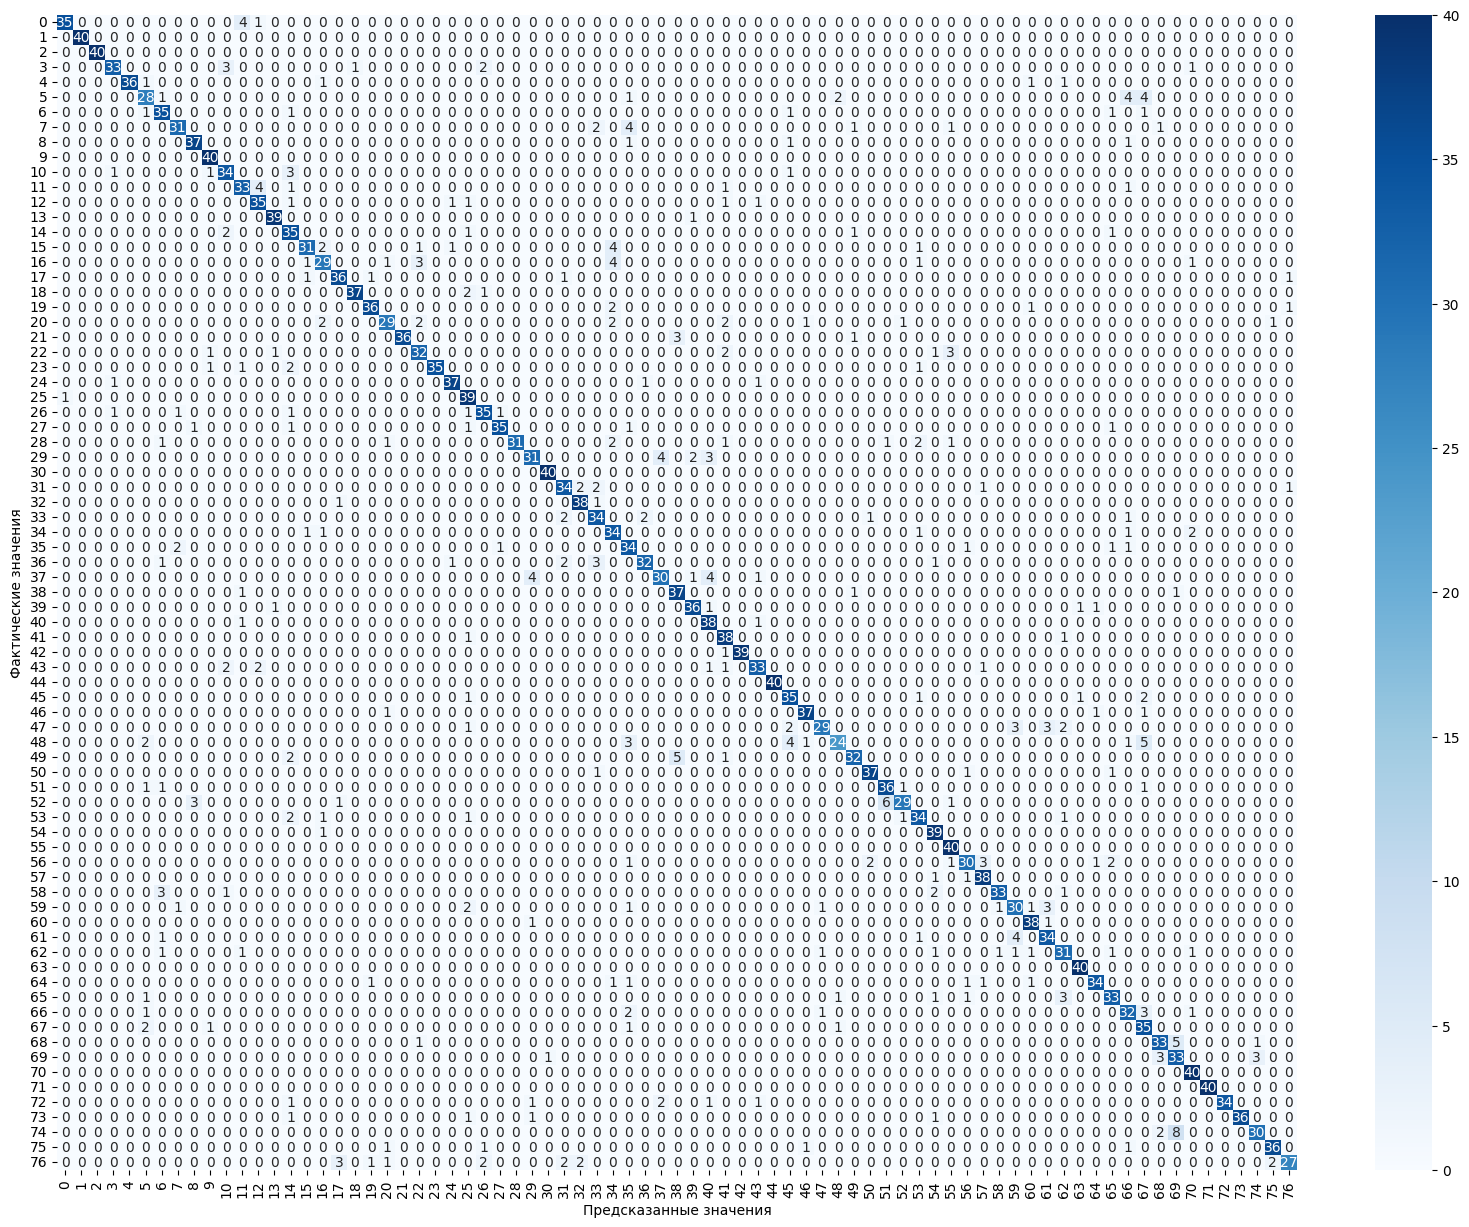

In [11]:
confusion_matrix_ = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20,15))
sb.heatmap(confusion_matrix_, annot=True, cmap='Blues')
plt.xlabel("Предсказанные значения")
plt.ylabel("Фактические значения")
plt.show()

Видим, что модель неплохо предсказывает фактические классы и немного ошибается. В среднем истинных предсказаний по каждому классу в райное ~33-35, что весьма неплохо.

## 2.6 Зарегистрируем лучшую модель с помощью MLflow

Сохраним нашу лучшую модель, это будет нашим базовым решением (baseline моделью), с которым мы будем сравнивать последующие модели

In [12]:
import mlflow.sklearn

X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

with mlflow.start_run(run_name="logreg_tfidf_baseline"):
    logistic_regression_pipeline.fit(X_train_full, y_train_full)

    test_metrics = evaluate(logistic_regression_pipeline, X_test, y_test)

    mlflow.log_params({
        "model": "LogisticRegression",
        "vectorizer": "TF-IDF",
        "ngram_range": "1-2",
        "max_features": 50000,
        "class_weight": "balanced"
    })

    mlflow.log_metrics(test_metrics)

    mlflow.sklearn.log_model(
        logistic_regression_pipeline,
        artifact_path="model",
        registered_model_name="Banking77_Classifier"
    )


2026/01/12 12:01:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/12 12:01:48 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/12 12:01:48 INFO mlflow.store.db.utils: Updating database tables
2026/01/12 12:01:48 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/12 12:01:48 INFO alembic.runtime.migration: Will assume non-transactional DDL.
Successfully registered model 'Banking77_Classifier'.
Created version '1' of model 'Banking77_Classifier'.


Переведем модель в продакшн

In [13]:
client = mlflow.tracking.MlflowClient()

client.transition_model_version_stage(
    name='Banking77_Classifier',
    version=1,
    stage='Production',
    archive_existing_versions=True
)

client.set_registered_model_alias(
    name="Banking77_Classifier",
    alias="production",
    version=1
)

C:\Users\kiril\AppData\Local\Temp\ipykernel_16380\3760124360.py:3: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


## Результаты этапа

В ходе выполнения второго этапа нашего проекта было сделано следующее:

- Провели векторизацию текстовых документов с помощью модели `TF-IDF`.
- Выделили пул метрик, по которым были оценены модели классического машинного обучения. Целевая метрика - `F1_macro`.
- Построили pipeline's для наших моделей.
- Обучили модели и оценили их на валидационной выборке. Эксперименты проводились с использованием библиотеки `MLflow`. Лучший результат по целевой метрике показала модель `LogisticRegression` (0.8445)
- Оценили лучшую модель на тестирующей выборке. Результат: f1_macro = 0.8655